In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
import matplotlib.patches as patches
import matplotlib.lines as mlines

from utils import SECTORS, DR_PRICES, NG_PRICES, NAT_GAS_NICE_NAMES, get_dataframe, get_scenario_name

In [29]:
# User defined variables
METHOD = "static" # "static" | "dynamic"
REGION = "caiso" # "caiso" | "new_england"

In [30]:
# Path handling (DO NOT CHANGE)
FIGURES_BASE = Path("..","figures","ramping")
FIGURES_METHOD = Path(FIGURES_BASE, REGION, METHOD)

In [31]:
def get_ldc(region: str, ng_price: str, sector: Optional[str] = None, dr_price: Optional[str] = None, method: Optional[str] = None) -> pd.Series:
    scenario = get_scenario_name(ng_price=ng_price, sector=sector, dr_price=dr_price)
    df = get_dataframe(region=region, method=method, ng_price=ng_price, sector=sector, dr_price=dr_price, result="ramping")
    return df[["Absolute 3-hr Ramping"]].rename(columns={"Absolute 3-hr Ramping":scenario}).squeeze().sort_values(ascending=False)

In [32]:
def get_data() -> dict[str,pd.DataFrame]:
    data = {}
    for ng_price in NG_PRICES:
        dfs = []
        dfs.append(get_ldc(region=REGION, ng_price=ng_price).to_frame(name="base").reset_index(drop=True).sort_values(by=["base"], ascending=False))
        for sector, price in product(SECTORS, DR_PRICES):
            df = get_ldc(region=REGION, ng_price=ng_price, sector=sector, dr_price=price, method=METHOD).to_frame()
            df = df.reset_index(drop=True).sort_values(by=[df.columns[0]], ascending=False)
            dfs.append(df)
        data[ng_price] = pd.concat(dfs, axis=1)
    return data

In [33]:
def generate_ldc(
    ng_price: str, include_title: bool = True, **kwargs
) -> tuple[plt.figure, plt.axes]:
    data = get_data()

    ncols = 2
    nrows = 1

    color_map = {
        "base": "k",
        "e": "tab:purple",
        "t": "tab:orange",
        "et": "tab:green",
    }

    linestyle_map = {
        "base": "-",
        "high": "-",
        "mid": "--",
        "low": "-.",
        "vlow": ":",
    }

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))

    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)

    df = data[ng_price]

    upper = df.max().max()
    lower = df.max().min()

    for col in df.columns:
        if col == "base":
            sector = "base"
            price = "base"
            label = "No DR"
        else:
            sector = col.split("-")[0]
            price = col.split("-")[1]
            label = f"{sector}-{price}"

        color = color_map[sector]
        linestyle = linestyle_map[price]

        df[col].plot(ax=axs[0], label=label, color=color, linestyle=linestyle)
        df[col].plot(
            ax=axs[1],
            xlim=(0, 50),
            ylim=(lower - 6000, upper + 2000),
            label=label,
            color=color,
            linestyle=linestyle,
        )

    rectangle = patches.Rectangle(
        (-10, lower - 4000),  # (x, y) of bottom-left corner
        50,  # Width of the rectangle
        (upper - lower + 5000),  # Height of the rectangle
        linewidth=2,
        edgecolor="red",
        facecolor="none",
        zorder=99,
    )
    axs[0].add_patch(rectangle)

    handles, labels = axs[0].get_legend_handles_labels()
    
    # for custom linewidth
    legend_handles = [
        mlines.Line2D(
            [],
            [],
            color=handle.get_color(),
            linewidth=2,
            linestyle=handle.get_linestyle(),
        )
        for handle in handles
    ]
    
    fig.legend(
        legend_handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1,
        frameon=False,
        fontsize=14
    )

    axs[0].tick_params(axis="both", labelsize=12)
    axs[1].tick_params(axis="both", labelsize=12)

    if include_title:
        fig.suptitle(f"{NAT_GAS_NICE_NAMES[ng_price]} Net Load Ramping Duration Curve", fontsize=20)

    fig.supxlabel("Day of Year", fontsize=18)
    fig.supylabel("Max 3hr Net Load Ramp (MW)", fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.99])

    return fig, axs

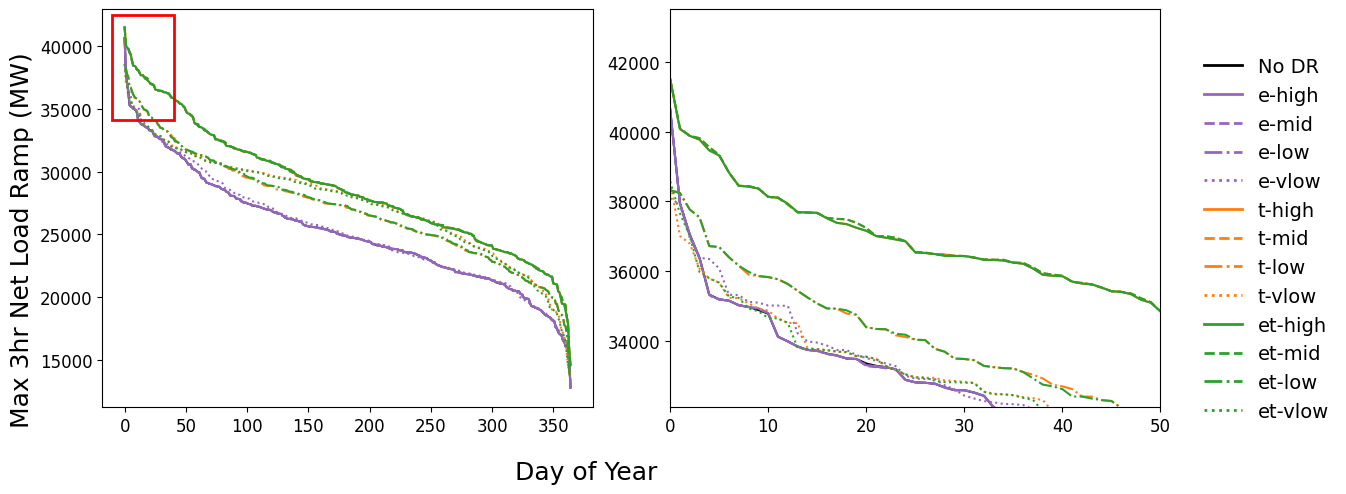

In [34]:
fig, _ = generate_ldc("lgas", include_title=False)
save_f = Path(FIGURES_METHOD, "lgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

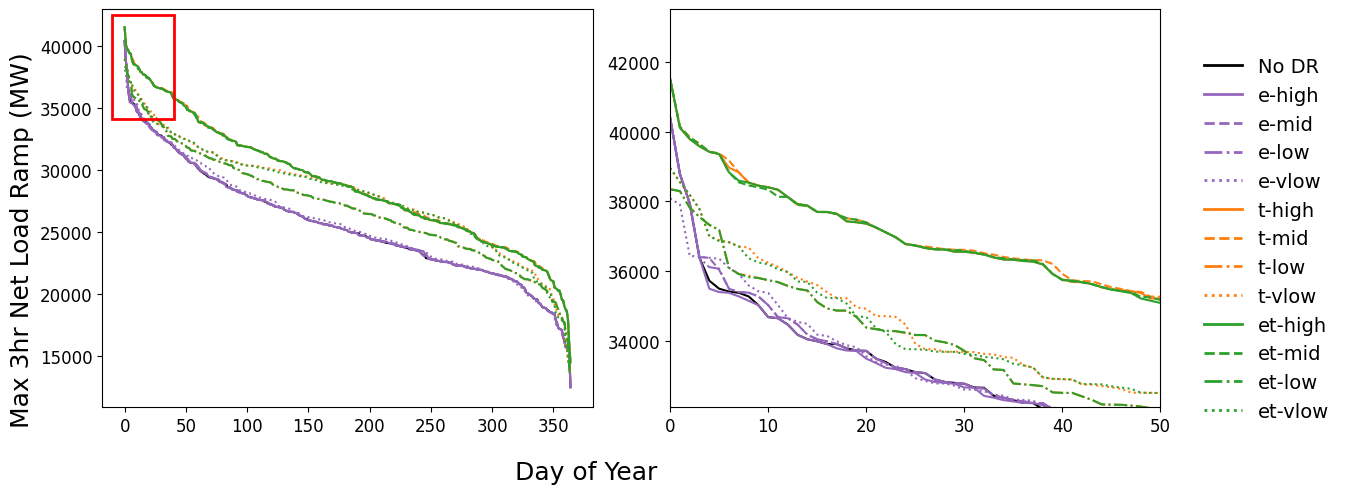

In [35]:
fig, _ = generate_ldc("mgas", include_title=False)
save_f = Path(FIGURES_METHOD, "mgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

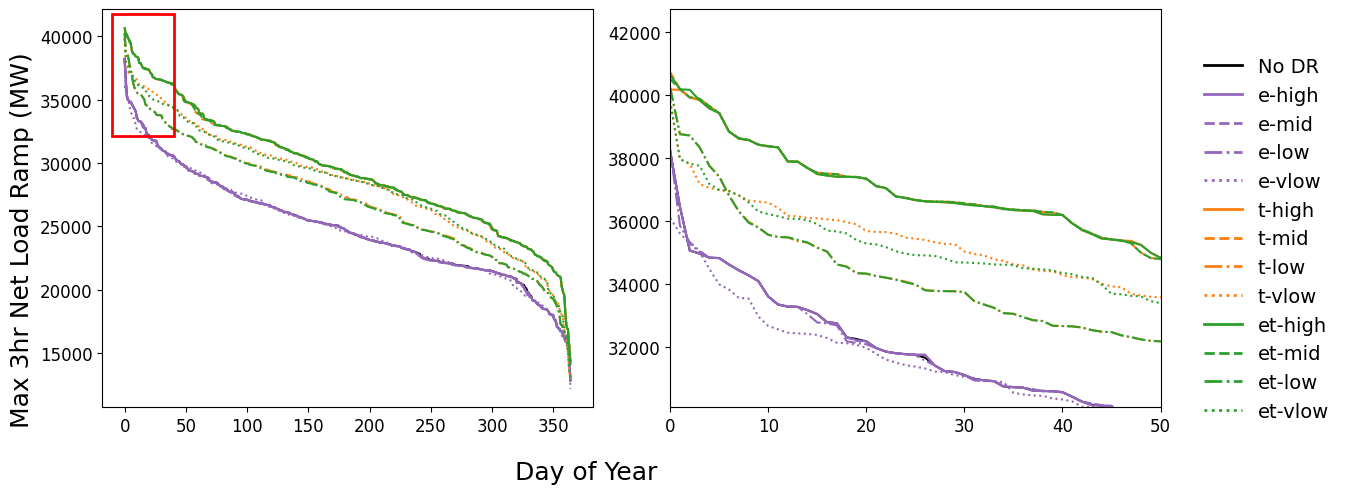

In [36]:
fig, _ = generate_ldc("hgas", include_title=False)
save_f = Path(FIGURES_METHOD, "hgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")